<a href="https://colab.research.google.com/github/w-okada/yolov7-onnx-test/blob/master/YOLOv7_ResolutionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv7 Resolution Test (for original weight and onnx)

In [1]:
import sys
import cv2
import matplotlib.pyplot as plt
import math
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0], sys.version_info(major=3, minor=7, micro=15, releaselevel='final', serial=0) 
Pytorch version: 1.12.1+cu113 


# Clone yolov7 repository and download weight(tiny)

In [2]:
!git clone --quiet https://github.com/WongKinYiu/yolov7  &> /dev/null
%cd yolov7
!git checkout 072f76c72c641c7a1ee482e39f604f6f8ef7ee92  &> /dev/null
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt   &> /dev/null

/content/yolov7


# Download Sample data

In [3]:
!git clone --quiet https://github.com/w-okada/yolov7-onnx-test.git &> /dev/null
!cp yolov7-onnx-test/data/D0002011239_00000.jpg ./sample.jpg

# Inference with original weight for various resolution

In [4]:
img_sizes = [160, 320, 640, 1280, 1920]
for img_size in img_sizes:
  print("processing... resolution:", img_size)
  !python detect.py --weights ./yolov7-tiny.pt --name exp{img_size} --exist-ok --conf 0.25 --img-size {img_size} --source sample.jpg &> /dev/null

processing... resolution: 160
processing... resolution: 320
processing... resolution: 640
processing... resolution: 1280
processing... resolution: 1920


# Show result

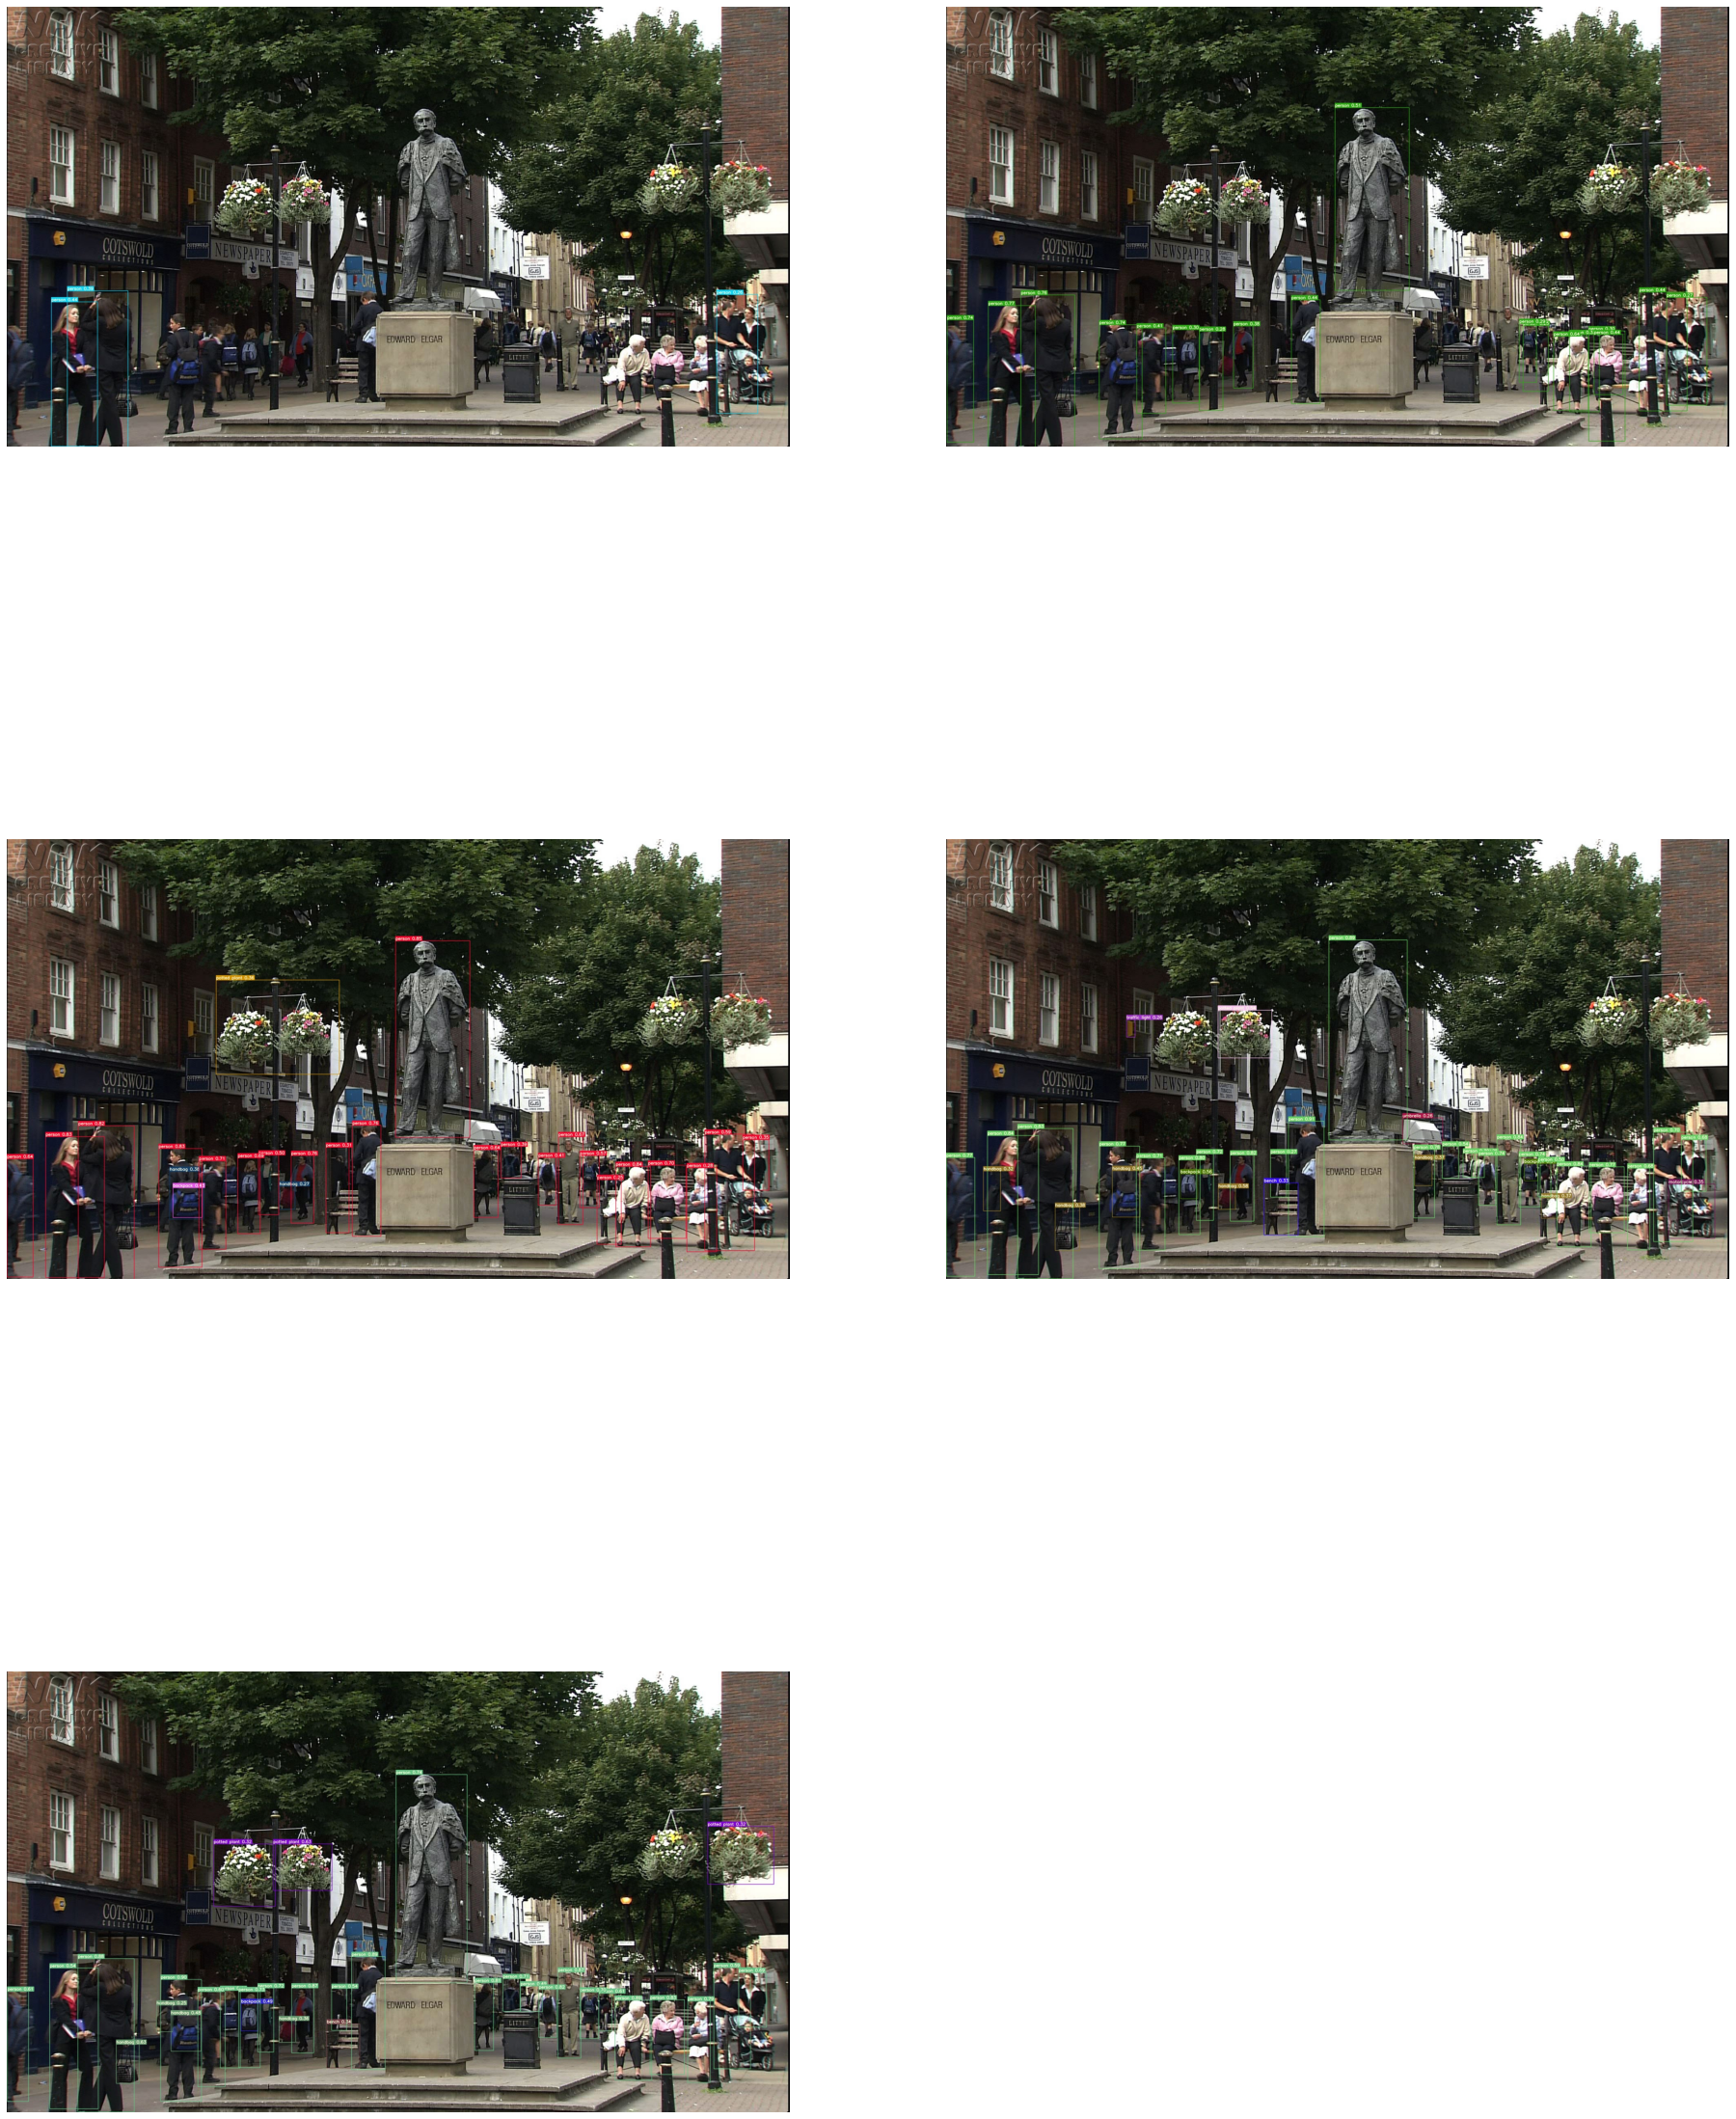

In [5]:
rows = math.ceil(len(img_sizes) / 2)
fig1 = plt.figure(figsize=(32,15*rows))
for i, img_size in enumerate(img_sizes):
  ax = fig1.add_subplot(rows, 2, i+1)
  img = cv2.imread(f"runs/detect/exp{img_size}/sample.jpg")
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  # ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
  ax.axis('off')

# Install modules for convert

In [6]:
!pip install onnx   &> /dev/null
!pip install onnxruntime  &> /dev/null
!pip install onnx-simplifier  &> /dev/null

In [7]:
for img_size in img_sizes:
  print("processing... resolution:", img_size)
  !python export.py --weights ./yolov7-tiny.pt --grid --end2end --simplify --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size {img_size} {img_size} --max-wh {img_size} &> /dev/null
  !mv ./yolov7-tiny.onnx ./yolov7-tiny-{img_size}.onnx

processing... resolution: 160
processing... resolution: 320
processing... resolution: 640
processing... resolution: 1280
processing... resolution: 1920


IMAGE_SIZE: 160
IMAGE_SIZE: 320
IMAGE_SIZE: 640
IMAGE_SIZE: 1280
IMAGE_SIZE: 1920


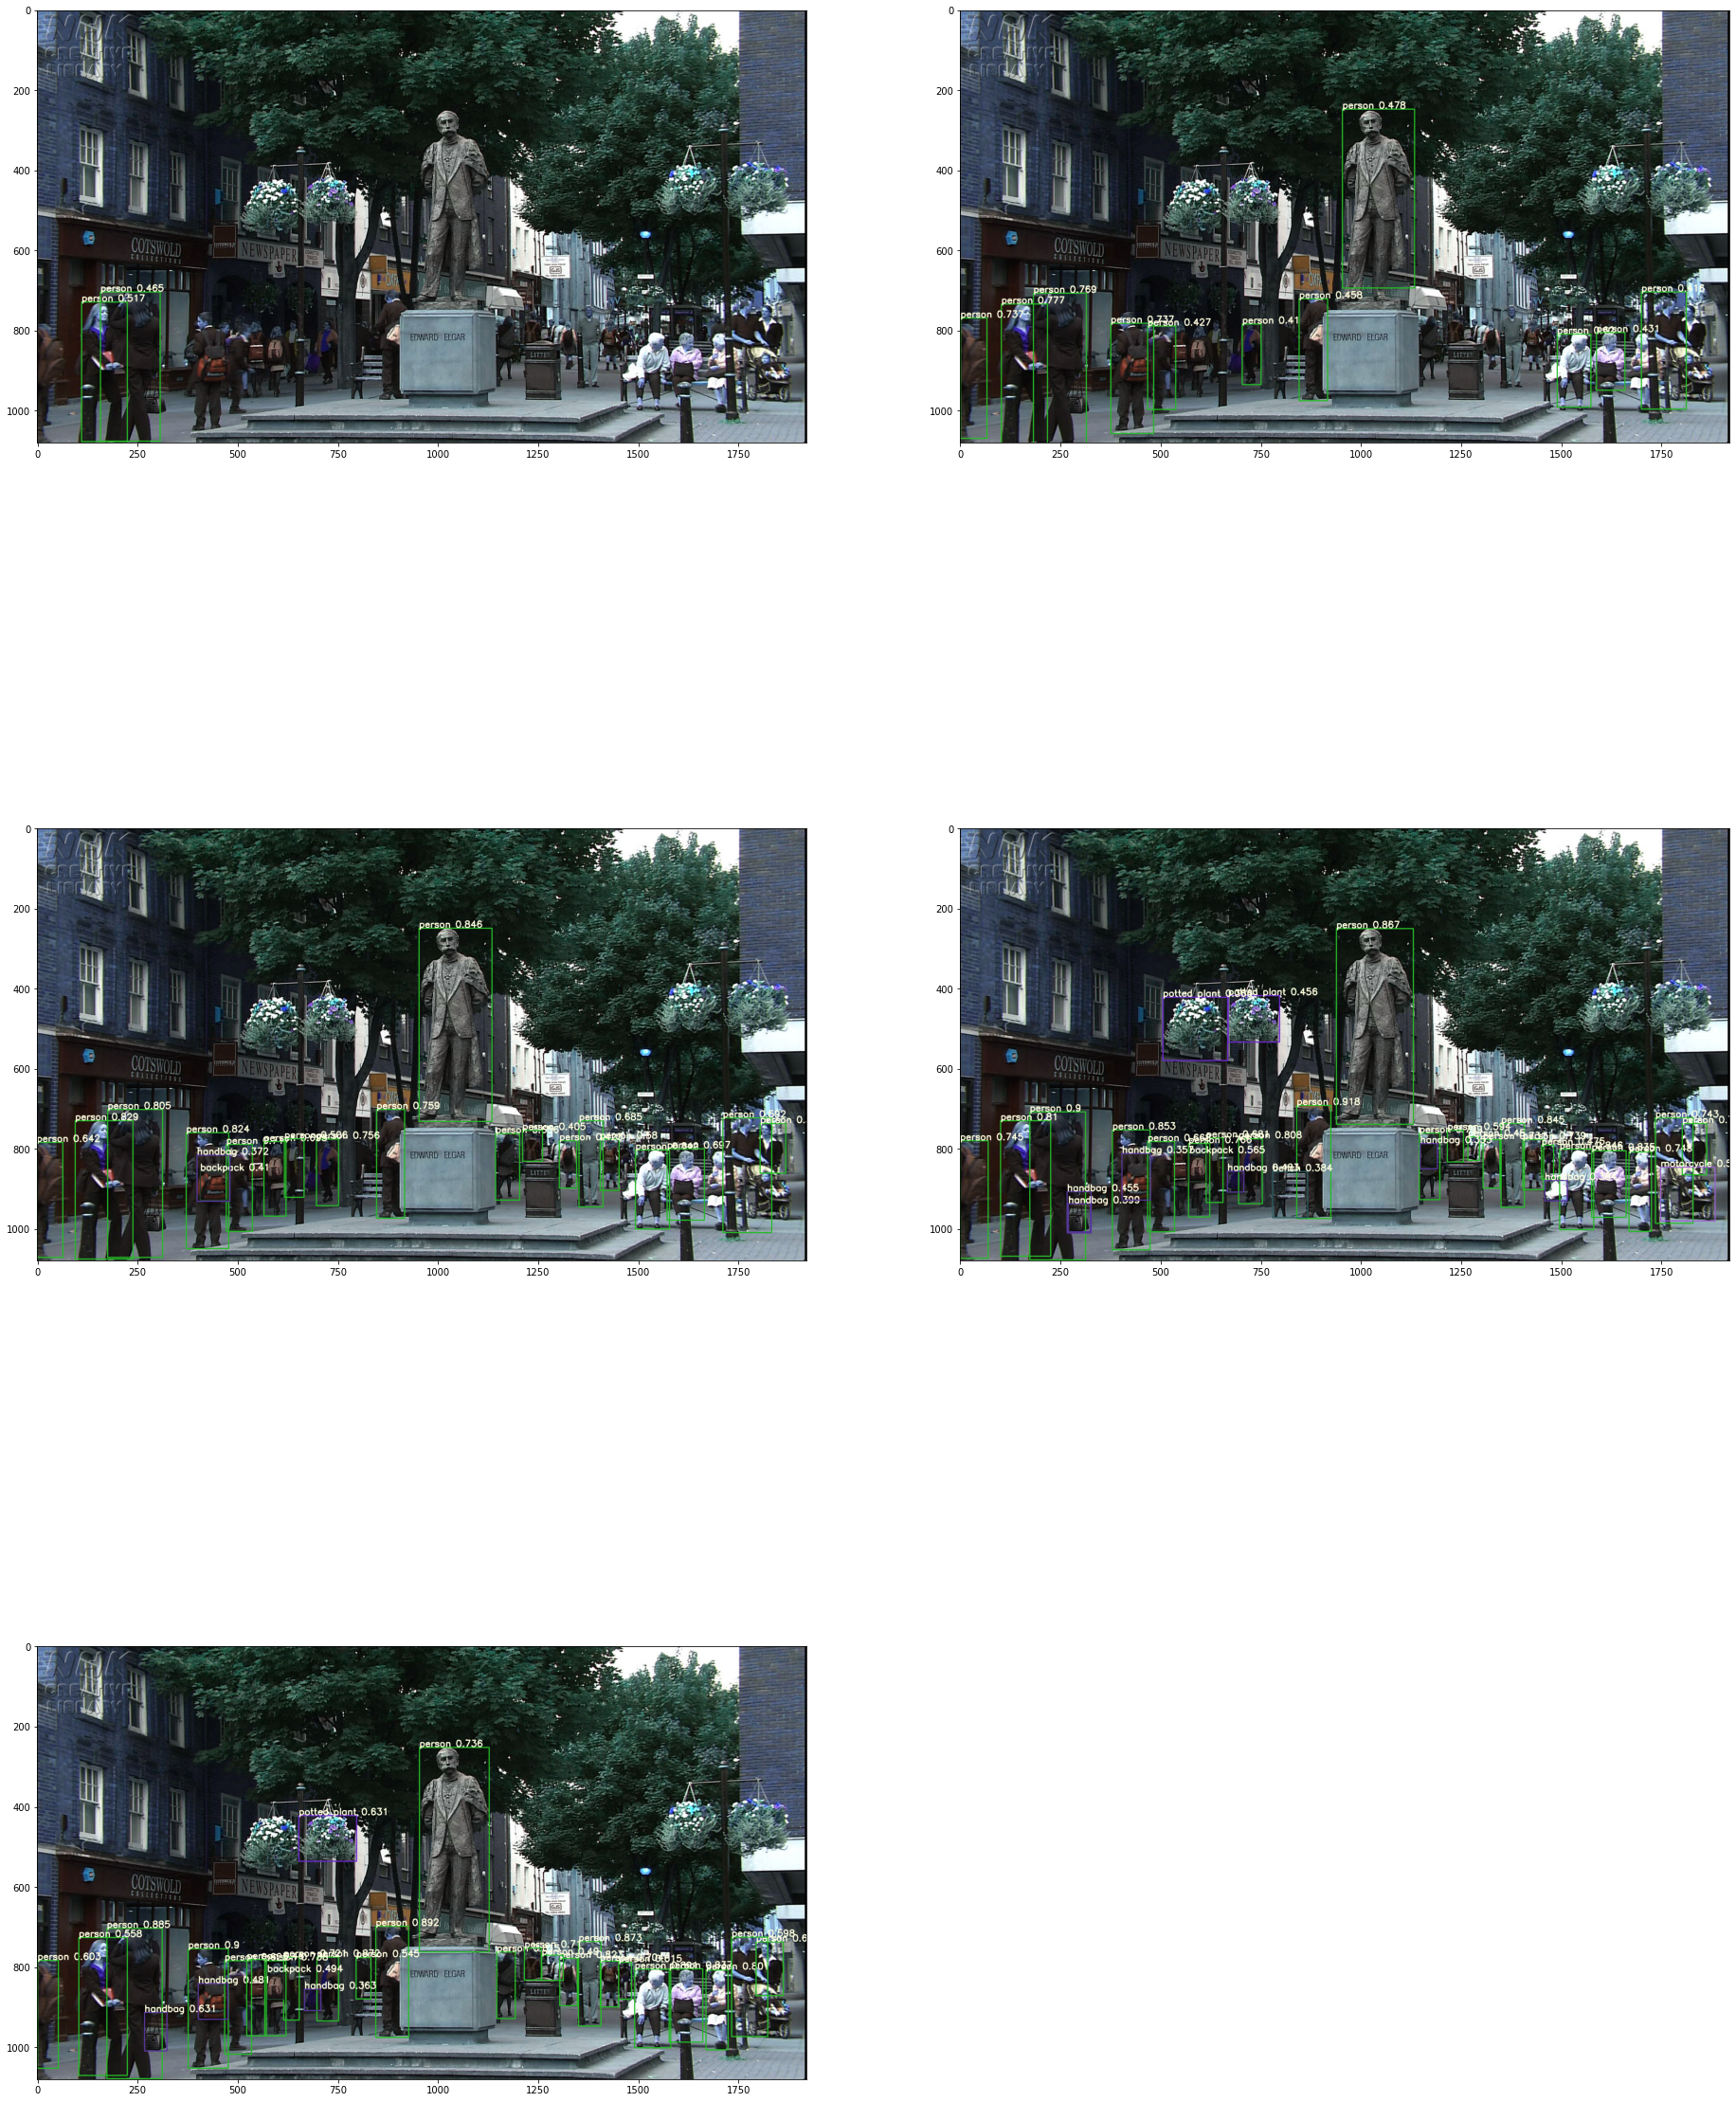

In [8]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple



def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

rows = math.ceil(len(img_sizes) / 2)
fig1 = plt.figure(figsize=(32,15*rows))



for num, img_size in enumerate(img_sizes):
  print("IMAGE_SIZE:", img_size)

  w = f"./yolov7-tiny-{img_size}.onnx"
  img = cv2.imread('sample.jpg')

  providers = ['CPUExecutionProvider']
  session = ort.InferenceSession(w, providers=providers)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  image = img.copy()
  image, ratio, dwdh = letterbox(image, new_shape=(img_size, img_size), auto=False)
  image = image.transpose((2, 0, 1))
  image = np.expand_dims(image, 0)
  image = np.ascontiguousarray(image)

  im = image.astype(np.float32)
  im /= 255
  im.shape

  outname = [i.name for i in session.get_outputs()]
  inname = [i.name for i in session.get_inputs()]

  inp = {inname[0]:im}
  outputs = session.run(outname, inp)[0]

  ori_images = [img.copy()]

  for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
      image = ori_images[int(batch_id)]
      box = np.array([x0,y0,x1,y1])
      box -= np.array(dwdh*2)
      box /= ratio
      box = box.round().astype(np.int32).tolist()
      cls_id = int(cls_id)
      score = round(float(score),3)
      name = names[cls_id]
      color = colors[name]
      name += ' '+str(score)
      cv2.rectangle(image,box[:2],box[2:],color,2)
      cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

  ax = fig1.add_subplot(rows, 2, num+1)
  ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# performance (non-reliable) 

In [9]:
import time
for img_size in img_sizes:
  print("IMAGE_SIZE:", img_size)

  w = f"./yolov7-tiny-{img_size}.onnx"
  img = cv2.imread('sample.jpg')

  providers = ['CPUExecutionProvider']
  session = ort.InferenceSession(w, providers=providers)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  image = img.copy()
  image, ratio, dwdh = letterbox(image, new_shape=(img_size, img_size), auto=False)
  image = image.transpose((2, 0, 1))
  image = np.expand_dims(image, 0)
  image = np.ascontiguousarray(image)

  im = image.astype(np.float32)
  im /= 255
  im.shape

  outname = [i.name for i in session.get_outputs()]
  outname

  inname = [i.name for i in session.get_inputs()]
  inname

  inp = {inname[0]:im}
  start_time = time.time()
  for i in range(10):
    outputs = session.run(outname, inp)[0]
  elapsed_time = time.time() - start_time
  print(img_size, 'fin. avr time:', (elapsed_time / 10) * 1000, "msec")

IMAGE_SIZE: 160
160 fin. avr time: 30.662059783935547 msec
IMAGE_SIZE: 320
320 fin. avr time: 76.06732845306396 msec
IMAGE_SIZE: 640
640 fin. avr time: 288.2974624633789 msec
IMAGE_SIZE: 1280
1280 fin. avr time: 1146.2405443191528 msec
IMAGE_SIZE: 1920
1920 fin. avr time: 2392.2442197799683 msec
